**1. IMPORTS AND SET UP**

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, accuracy_score


In [2]:
# Load the articles dataset
script_dir = os.path.abspath('')
csv_path = os.path.join(script_dir, "..", "data", "articles_labeled.csv")
articles_df = pd.read_csv(csv_path, sep=";", encoding="utf-16", engine="python")

# Preview the first few rows of the dataset
articles_df.head()

,Full_text,Article_ID,Outlet,Date,Team,Title,Topic
0,Given his current employers’ well-documented i...,755,TheGuardian,30/07/2025 8:07,Arsenal,Football transfer rumours: Manchester United m...,0
1,Liverpool winger Luis Diaz has completed a £65...,750,BBC,30/07/2025 8:01,Liverpool,Bayern Munich sign Liverpool winger Diaz for £65,0
2,Manchester United defender Luke Shaw has backe...,751,BBC,30/07/2025 8:00,Manchester United,Shaw backs Amorim's hard-line 'demands',4
3,Manchester United defender Luke Shaw has sugge...,747,SkySports,30/07/2025 7:47,Manchester United,Shaw: There are no stragglers in Man Utd squad...,3
4,James Trafford has joined Manchester City from...,748,SkySports,29/07/2025 21:52,Manchester City,Man City re-sign Trafford from Burnley,0


We visualize the topics in the whole dataset and observe that there are two main topics, with the rest not being very frquent. This poses a problem of unbalanced classes that we will have to take into account later

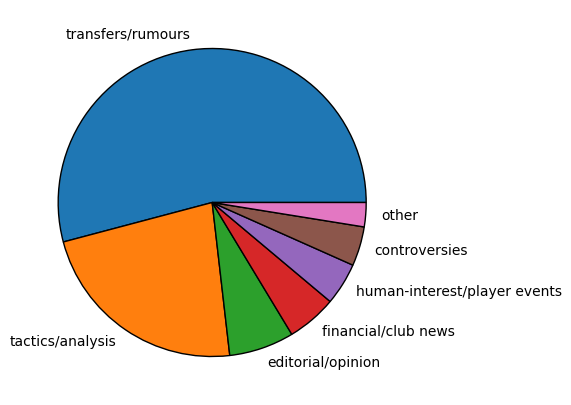

In [3]:
# Map topic indices to their corresponding names
TOPICS_MAPPING = {
    0: "transfers/rumours",
    1: "financial/club news",
    2: "controversies",
    3: "tactics/analysis",
    4: "editorial/opinion",
    5: "human-interest/player events",
    6: "other"
}

topics_ocurrences = articles_df['Topic'].value_counts()

# Create a pie chart to visualize the distribution of topics
plt.rcParams["figure.figsize"] = (20,5)
labels = [TOPICS_MAPPING[idx] for idx in topics_ocurrences.index]
plt.pie(topics_ocurrences,
        labels=labels,
        wedgeprops = { 'linewidth': 1, 'edgecolor': 'black'})
plt.show()

We split the dataset into train and test using stratification due to the unbalanced classes problem

In [3]:
# The target variable is 'Topic' and the feature is 'Full_text' (the whole article text)
y = articles_df['Topic'].tolist()
X = articles_df['Full_text'].tolist()

# Split with stratification and a 70-30 train-test ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

**2. EXPLORATION OF MODELS**

Firstly we use BERT to produce an embedding of the text of the article (the feature), in both the train and test set.

In [4]:
# Loading the pre-trained BERT model for sentence embeddings
sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Encoding the training and test data to obtain embeddings
X_train_emb = sbert.encode(X_train, show_progress_bar=True)
X_emb_test = sbert.encode(X_test, show_progress_bar=True)

# Display the shapes of the embeddings
print(f"X_train_emb shape: {X_train_emb.shape}")
print(f"X_emb_test shape: {X_emb_test.shape}")

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

X_train_emb shape: (441, 384)
X_emb_test shape: (189, 384)


We will firstly try multinomial logistic regression. For evaluating the performance of the models we will use the confusion matrix as well as the balanced accuracy (accuracy across classes).

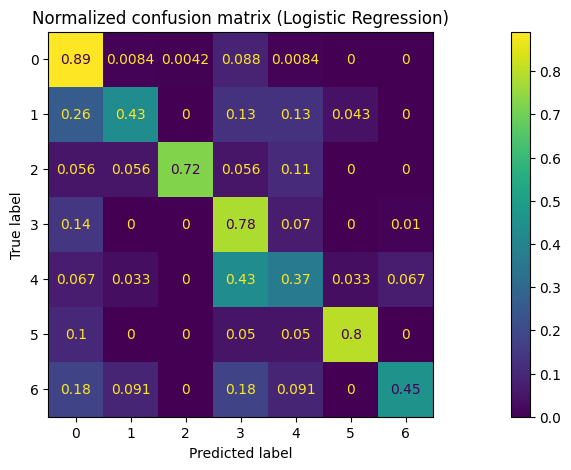

Balanced Accuracy: 0.6364 (0.0700)


In [6]:
# Create a logistic regression pipeline
log_clf = make_pipeline(
    StandardScaler(),          # standardize the features
    LogisticRegression(
        solver='lbfgs',             # a common solver for multinomial logistic regression
        class_weight='balanced',    # balance the classes
        C=1.0                       # 1.0 penalty term for l2 regularization
    )).fit(X_train_emb, y_train)

# Evaluate the model using cross-validation 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
log_predictions = cross_val_predict(log_clf, X_train_emb, y_train, cv=cv)

# Plot the confusion matrix for the logistic regression model
log_disp = ConfusionMatrixDisplay.from_predictions(
    y_train, 
    log_predictions,
    labels=log_clf.classes_,
    normalize='true',       # <-- normalize per true class
    display_labels=log_clf.classes_
)
log_disp.ax_.set_title("Normalized confusion matrix (Logistic Regression)")
plt.show()

# Calculate the balanced accuracy score for the logistic regression model
log_scores = cross_val_score(log_clf, X_train_emb, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
print(f'Balanced Accuracy: {np.mean(log_scores):.4f} ({np.std(log_scores):.4f})')

Next we will try an SVM with RBF kernel.

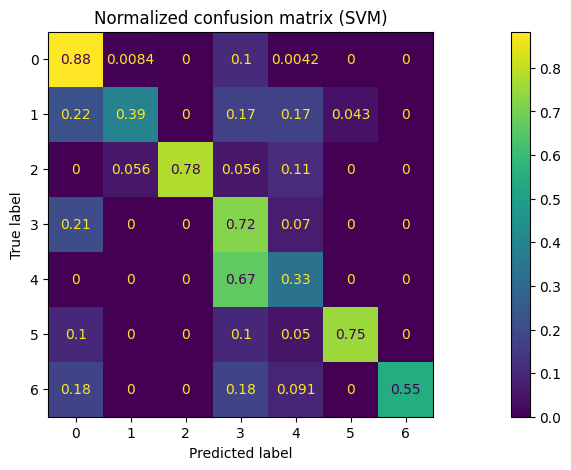

Balanced Accuracy: 0.6304 (0.0351)


In [7]:
# Create a SVM classifier pipeline
svm_clf = make_pipeline(
    StandardScaler(),         # standardize features 
    SVC(
        class_weight='balanced',  # balance the classes
        kernel="rbf",             # radial basis function kernel
        C=1.0                     # 1.0 penalty term for regularization
    )).fit(X_train_emb, y_train)

# Evaluate the SVM model using cross-validation
svm_predictions = cross_val_predict(svm_clf, X_train_emb, y_train, cv=cv)

# Plot the confusion matrix for the SVM model
svm_disp = ConfusionMatrixDisplay.from_predictions(
    y_train, 
    svm_predictions,
    labels=svm_clf.classes_,
    normalize='true',       # <-- normalize per true class
    display_labels=svm_clf.classes_
)
svm_disp.ax_.set_title("Normalized confusion matrix (SVM)")
plt.show()

# Calculate the balanced accuracy score for the SVM model
svm_scores = cross_val_score(svm_clf, X_train_emb, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
print(f'Balanced Accuracy: {np.mean(svm_scores):.4f} ({np.std(svm_scores):.4f})')


Finally we will try a gradient boosting classifier. 

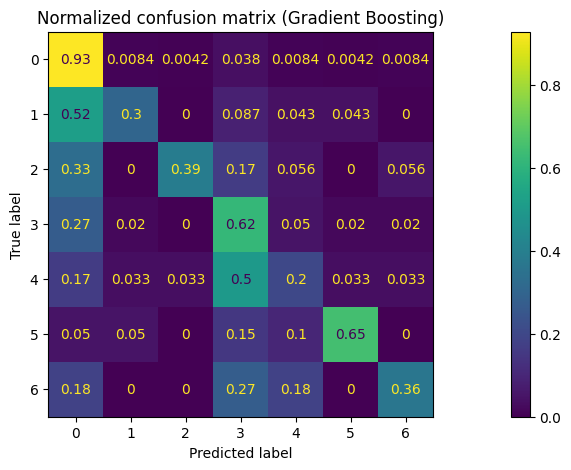

Balanced Accuracy: 0.4989 (0.0285)


In [8]:
# Create a Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
).fit(X_train_emb, y_train)

# Evaluate the Gradient Boosting model using cross-validation
gb_predictions = cross_val_predict(gb_clf, X_train_emb, y_train, cv=cv)

# Plot the confusion matrix for the Gradient Boosting model
gb_disp = ConfusionMatrixDisplay.from_predictions(
    y_train, 
    gb_predictions,
    labels=gb_clf.classes_,
    normalize='true',       
    display_labels=gb_clf.classes_
)
gb_disp.ax_.set_title("Normalized confusion matrix (Gradient Boosting)")
plt.show()

# Calculate the balanced accuracy score for the Gradient Boosting model
gb_scores = cross_val_score(gb_clf, X_train_emb, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
print(f'Balanced Accuracy: {np.mean(gb_scores):.4f} ({np.std(gb_scores):.4f})')

We see that the best models across classes seem to Logistic Regression and the SVM. Finally we will use Logistic Regression, since it tends to predict less the majority classes, having a more balanced prediction. Other models might also be considered in the future, but we have to take into account that the proportion of each class will vary over time, since the data has been collected in the off-season where most of the news are transfers. 

**3. CREATING AND EVALUATING THE FINAL MODEL**

We perform hyperparameter tuning with cross validation to obtain the optimal penalty term for the Logistic Regression model.

> 0.0: mean 0.6613 (±0.0972)
> 5e-05: mean 0.7193 (±0.0806)
> 0.0001: mean 0.7269 (±0.0827)
> 0.0005: mean 0.7067 (±0.0985)
> 0.001: mean 0.7019 (±0.0937)
> 0.005: mean 0.6955 (±0.0987)
> 0.01: mean 0.6958 (±0.0964)
> 0.05: mean 0.6845 (±0.0981)
> 0.1: mean 0.6721 (±0.1012)
> 0.5: mean 0.6588 (±0.0986)
> 1.0: mean 0.6551 (±0.0992)


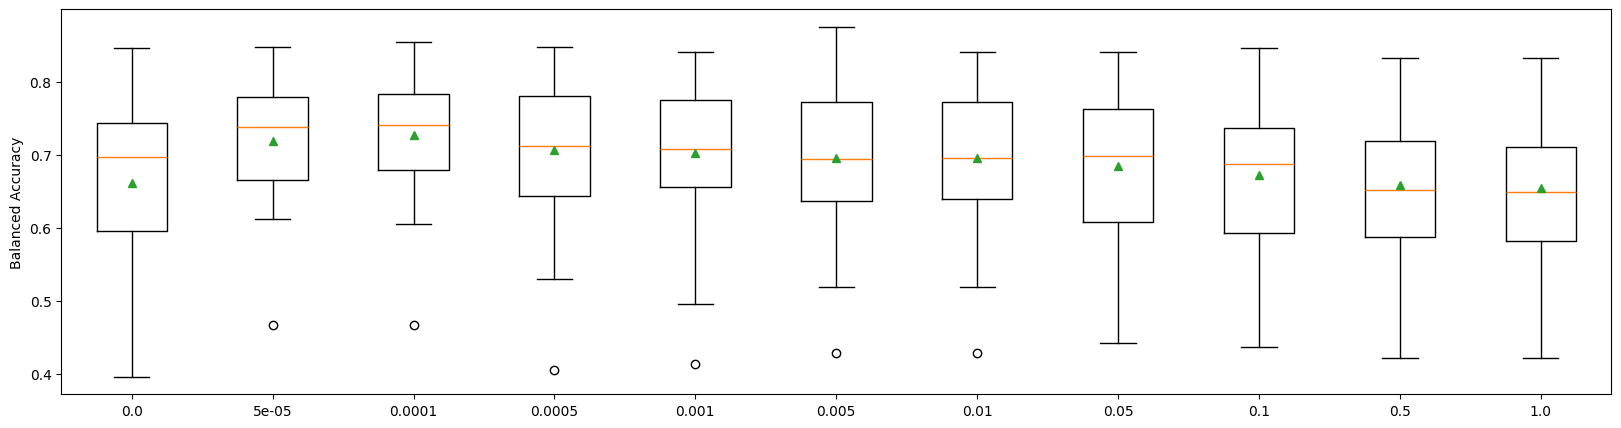

In [9]:
def get_models(penalties):
    """Create logistic regression models with different penalties"""
    models = {}
    # Iterate over the list of penalties
    for p in penalties:
		# Create the name for the model
        key = f"{p}"
		# Turn off penalty when it is zero
        if p == 0.0:
            models[key] = make_pipeline(
				StandardScaler(),  # standardize features
				LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty=None, class_weight='balanced'))
        else:
            models[key] = make_pipeline(
                StandardScaler(),  # standardize features
                LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p, class_weight='balanced'))
    
    return models

def evaluate_model(model, X, y):
	"""Evaluate a model using cross-validation and return the scores"""
	# Define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# Evaluate the model and extract the balanced accuracy scores
	scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
     
	return scores

# Define a list of penalties to test anc create models
PENALTIES = [0.0, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
models = get_models(PENALTIES)

# Evaluate the models and store results
results, names = [], []
for name, model in models.items():
	# Evaluate the model and collect the scores
	scores = evaluate_model(model, X_train_emb, y_train)
	results.append(scores)
	names.append(name)
	# Summarize progress along the way
	print(f"> {name}: mean {np.mean(scores):.4f} (±{np.std(scores):.4f})")
     
# Plot model performance for comparison
plt.boxplot(results, tick_labels=names, showmeans=True)
plt.ylabel("Balanced Accuracy")
plt.show()

After obtaining the best possible penalty, we proceed to create and evaluate the final model.

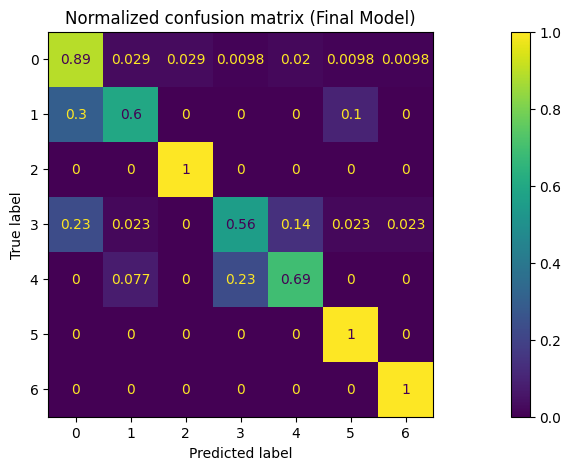

Balanced Accuracy: 0.820
Overall Accuracy: 0.799


In [10]:
# Create the final model using the best parameters from the search
final_clf = make_pipeline(
    StandardScaler(),  # standardize the features
    LogisticRegression(
    solver='lbfgs',
    class_weight='balanced',  
    C=0.0001                  # the best penalty term found in the search
)).fit(X_train_emb, y_train)

# Evaluate the final model using cross-validation
final_predictions = final_clf.predict(X_emb_test)

# Display the normalized confusion matrix for the final model
final_disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    final_predictions,
    labels=final_clf.classes_,
    normalize='true',       
    display_labels=final_clf.classes_)
final_disp.ax_.set_title("Normalized confusion matrix (Final Model)")
plt.show()

# Calculate the balanced accuracy and overall accuracy for the final model
balanced_acc = balanced_accuracy_score(y_test, final_predictions)
overall_acc = accuracy_score(y_test, final_predictions)
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Overall Accuracy: {overall_acc:.3f}")

We see that there are many classes that have been correctly guessed with the most trouble in classes 3 and 4 (tactics/analysis and editorial/opinion), since these classes are very similar and sometimes hard to differentiate by myself. Thus, we are confident that our results will overall provide good insights to the articles, by having an ~80% balanced and overall accuracy.

In [ ]:
# save model
from joblib import dump, load
from pathlib import Path
import json
import datetime

MODEL_DIR = Path("../app/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Get the filename
timestamp = datetime.datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
model_filename = MODEL_DIR / f"topic_clf_v1_{timestamp}.joblib"

# Train on the whole data 
y = articles_df['Topic'].tolist()
X = articles_df['Full_text'].tolist()
X_emb = sbert.encode(X, show_progress_bar=True)

# Final model found
final_clf = make_pipeline(
    StandardScaler(),  # standardize the features
    LogisticRegression(
    solver='lbfgs',
    class_weight='balanced',  
    C=0.0001                  # the best penalty term found in the search
)).fit(X_emb, y)

# Dump the model
dump(final_clf, model_filename)  

# Save metadata
metadata = {
    "filename": str(model_filename.name),
    "created_at": timestamp,
    "model_type": "sklearn.pipeline.Pipeline(LogisticRegression)",
    "classes": list(final_clf.named_steps['logisticregression'].classes_.tolist()),
    "notes": "C=0.0001, class_weight=balanced"
}
with open(MODEL_DIR / f"{model_filename.stem}.meta.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Saved model to", model_filename)

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Saved model to ..\app\models\topic_clf_v1_20250809T153500Z.joblib
